# framework RACC

Ce framework a pour objectif de mettre en place la méthode RACC sur des données MO (SSMIS) et IR (Meteosat)
Les changements à faire dans le code sont marqués par le mot clé TODO

## imports

In [2]:
# reloading 
%load_ext autoreload
%autoreload 2

# importing librairies
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, date, timedelta
from scipy.stats import pearsonr, spearmanr

import json
import glob
import sys
import warnings
import os

# importing modules from RACC directory
from classification import classification
import ground_truth as gt

# importing modules from Images
sys.path.insert(0, r'../Images')
from Image import Image
from File import File
from Geotiff_Format import Geotiff_Format

# importing meteosat API modules
sys.path.insert(0, r'API_meteosat')
from eds_get_nearest import search_nearest,download_dataset
sys.path.insert(0, r'API_nsidc')
from SSMIS_download import download_Meteosat_images

## Initialisation des variables principales

On définit les chemins d'accès principaux afin d'obtenir les variables utiles dans tout le code

In [3]:
def get_index(index_path):
    with open(index_path, "r", encoding="utf-8") as json_dict:
        index = json.load(json_dict)
    return index
    
def save_index(index,index_path):
    with open(index_path, 'w', encoding="utf-8") as json_dict:
        json.dump(index, json_dict, indent=4, default=str)
        
def make_directory(path):
    if not os.path.exists(path):
        os.makedirs(path)
    return path

In [4]:
# TODO : remplir le chemin d'accès au dossier principal où tous les fichiers seront générés
main_dir = make_directory(r"../../data/RACC/dec_2020")

# TODO : remplir le chemin d'accès au fichier json contenant les dates et leurs différents attributs
index_path = main_dir + r"/acq_dates.json"

# TODO : remplir le chemin d'accès au fichier json contenant les paramètres de la projection comme la résolution et l'emprise
projection_path = r"../../data/param_proj/param_guy.json"

# TODO : compléter les dates visées dans le format suivant
target_dates = [
    "2020-12-01T20:00:00.000000+0000",
    "2020-12-05T20:00:00.000000+0000",
    "2020-12-08T16:00:00.000000+0000",
    "2020-12-09T12:00:00.000000+0000",
    "2020-12-11T12:00:00.000000+0000",
    "2020-12-12T12:00:00.000000+0000",
    "2020-12-15T06:00:00.000000+0000",
    "2020-12-17T12:00:00.000000+0000",
    "2020-12-19T12:00:00.000000+0000",
    "2020-12-20T06:00:00.000000+0000",
    "2020-12-24T12:00:00.000000+0000",
    "2020-12-29T12:00:00.000000+0000",
    "2020-12-30T02:00:00.000000+0000"
]

projection = json.load(open(projection_path, "r", encoding="utf-8"))
format = "%Y-%m-%dT%H:%M:%S.%f%z"

index = {d.split(" ")[0]:{"target":d} for d in target_dates}
#index = {}
#save_index(index,index_path)   # peut supprimer un fichier courant

## Extraction des images SSMIS 

In [24]:
def prepare_SSMIS(index_path, SSMIS_src_dir, SSMIS_proj_dir, attribute, projection, format = "%Y-%m-%dT%H:%M:%S.%f%z"):
    index = {}
    fns = glob.glob(SSMIS_src_dir + r"/*/*.nc")
    
    for fn in fns:
        [yyyyddd,freq] = fn.split("NSIDC-0630-EASE2_")[-1].split("-")[2:4]
        file = File(fn)
        start_date,end_date = file.getAcqDates()
        mean_date_str = datetime.strftime(start_date + (end_date - start_date)/2,"%Y-%m-%d")
        tif_filename = SSMIS_proj_dir + rf"/SSMIS_{attribute}_{freq}_{yyyyddd}.tiff"
        file.project(projection,attribute,out_path=tif_filename)
        
        index[mean_date_str] = {}
        index[mean_date_str][f"SSMIS_src_{freq}"] = fn
        index[mean_date_str][f"start_date_{freq}"] = datetime.strftime(start_date,format)
        index[mean_date_str][f"end_date_{freq}"] = datetime.strftime(end_date,format)
        index[mean_date_str][f"SSMIS_tif_{freq}"] = tif_filename

        save_index(index,index_path)

SSMIS_src_dir = make_directory(r"../../data/SSMI/download_dec_2020/telechargement_internet")
SSMIS_proj_dir = make_directory(main_dir + r"/SSMIS")
prepare_SSMIS(index_path, SSMIS_src_dir, SSMIS_proj_dir, "TB", projection,format)


In [35]:
def download_SSMIS(index_path, SSMIS_src_dir, SSMIS_proj_dir, attribute, projection, research_parameters):
    index = get_index(index_path)
    for d in index.keys():
        # téléchargement des données
        retour = download_Meteosat_images(d,SSMIS_src_dir,projection,research_parameters)
        tg_freq = research_parameters["freq"][0]
        if retour:
            src_filename,start_date,end_date = retour
            file = File(src_filename) ; string_d = d[:10]
            tif_filename = SSMIS_proj_dir + rf"/SSMIS_{attribute}_{tg_freq}_{string_d}.tiff"
            file.project(projection,attribute,out_path=tif_filename)

            index[d][f"SSMIS_src_{tg_freq}"] = src_filename
            index[d][f"start_date_{tg_freq}"] = datetime.strftime(start_date,format)
            index[d][f"end_date_{tg_freq}"] = datetime.strftime(end_date,format)
            index[d][f"SSMIS_tif_{tg_freq}"] = tif_filename
            save_index(index,index_path)
        else:
            print(f"aucun fichier n'a été trouvé pour la date {d}")
        

In [ ]:
SSMIS_src_dir = make_directory(r"../../data/SSMI/download_dec_2020")
SSMIS_proj_dir = make_directory(main_dir + r"/SSMIS")

research_parameters = {
        "freq":["91V","91V","91V","91V","91V","91V"],
        "passage":["A","E","A","E","*","*"],
        "capteur":["F17_SSMIS","F17_SSMIS","F17_SSMIS","F16_SSMIS","F18_SSMIS"],
        "algo":["SIR","SIR","SIR","SIR","SIR"],
        "grid":["T3.125km","N3.125km","T3.125km","T3.125km","T3.125km"]
        }
download_SSMIS(index_path, SSMIS_src_dir, SSMIS_proj_dir, "TB", projection, research_parameters)


research_parameters = {
        "freq":["91H","91H","91H","91H","91H"],
        "passage":["A","E","A","E","*","*"],
        "capteur":["F17_SSMIS","F17_SSMIS","F17_SSMIS","F16_SSMIS","F18_SSMIS"],
        "algo":["SIR","SIR","SIR","SIR","SIR"],
        "grid":["T3.125km","N3.125km","T3.125km","T3.125km","T3.125km"]
        }
download_SSMIS(index_path, SSMIS_src_dir, SSMIS_proj_dir, "TB", projection, research_parameters)

## Extraction des images SEVIRI

In [4]:
def download_SEVIRI(    index_path, 
                        SEVIRI_src_dir, 
                        path_API_keys = r"../../data/keys/eds.key",
                        nb_files_per_period=12,
                        format="%Y-%m-%dT%H:%M:%S.%f%z"):

    zipped_dir,unzipped_dir = make_directory(SEVIRI_src_dir+r"/zipped"),make_directory(SEVIRI_src_dir+r"/unzipped")

    index = get_index(index_path)
    prod_list = []
    for d in index.keys():
        index[d]["Meteosat_imgs"] = {}
        try :
            start_acq_date = datetime.strptime(index[d]["start_date_91V"],format)
            end_acq_date = datetime.strptime(index[d]["end_date_91V"],format)
        except:
            print(f"aucun fichier n'a été trouvé pour la date {d}")
            pass
        delta = timedelta(seconds=(end_acq_date - start_acq_date).total_seconds() / nb_files_per_period)
        researched_dates = [start_acq_date + i*delta for i in range(nb_files_per_period)]
        print(len(researched_dates))
        for i in range(len(researched_dates)):
            res_d = researched_dates[i]
            print(res_d)
            prod, Meteosat_date = search_nearest(res_d)
            
            filename = fr"{unzipped_dir}/{prod}.nat"
            index[d]["Meteosat_imgs"][i] = {    "file": filename,
                                                "date": datetime.strftime(Meteosat_date,format)}
            if os.path.exists(filename):
                print(f"le fichier {filename} a déjà été téléchargé")
            else:
                prod_list.append(prod)
            
            
    """
                
    print(f"téléchargement de {len(prod_list)} images")
    download_dataset(prod_list,zipped_dir,unzipped_dir,path_API_keys)
    save_index(index,index_path)
    """


def prepare_SEVIRI_images(index_path, out_dir, attribute, projection):
    """
    prépare les images SEVIRI en réalisant leur extraction, leur projection et leur agrégation

    Args : 
        index_path (string) : chemin d'accès au fichier json contenant les informations sur les fichiers images
        out_dir (string) : chemin vers le dossier où enregistrer les images
        attribute (string) : attribut à extraire
        projection (dict) : dictionnaire contenant les paramètres de projection, notamment l'emprise 

    "Meteosat_imgs": {
            "0": {
                "file": "../../data/SEVIRI/dec_2020/unzipped/MSG4-SEVI-MSG15-0100-NA-20201201171243.037000000Z-NA.nat",
                "date": "2020-12-01T17:12:43.000000+0000"
            },...
        }
    """
    index = get_index(index_path)
    for d in index.keys():
        images_dict = index[d]["Meteosat_imgs"]
        arrays_SEVIRI_d = []
        for img_idx in images_dict.keys():
            try:
                SEVIRI_file = File(images_dict[img_idx]["file"])
                img_proj = SEVIRI_file.project(projection,attribute)
                arrays_SEVIRI_d.append(img_proj.array)
            except FileNotFoundError :
                print(f"le fichier {SEVIRI_file.path} n'a pas été trouvé")
                pass
        img_proj_agreg = Image(np.mean(np.array(arrays_SEVIRI_d),axis=0),img_proj.lons,img_proj.lats)
        filename = out_dir + rf"/TB_SEVIRI_{attribute}_{d[:10]}.tiff"
        img_proj_agreg.save(projection,filename)
        index[d][f"SEVIRI_{attribute}_tif"] = filename
    save_index(index,index_path)
        

In [5]:
SEVIRI_src_dir = make_directory(r"../../data/SEVIRI/dec_2020")
SEVIRI_proj_dir = make_directory(main_dir + r"/SEVIRI")

download_SEVIRI(index_path,SEVIRI_src_dir,nb_files_per_period=12,format=format)

#prepare_SEVIRI_images(index_path, SEVIRI_proj_dir, "IR_108", projection)

12
2020-12-01 00:56:00+00:00
2020-12-01 02:49:40+00:00
2020-12-01 04:43:20+00:00
2020-12-01 06:37:00+00:00
2020-12-01 08:30:40+00:00
2020-12-01 10:24:20+00:00
2020-12-01 12:18:00+00:00
2020-12-01 14:11:40+00:00
le fichier ../../data/SEVIRI/dec_2020/unzipped/MSG4-SEVI-MSG15-0100-NA-20201201141243.680000000Z-NA.nat a déjà été téléchargé
2020-12-01 16:05:20+00:00
le fichier ../../data/SEVIRI/dec_2020/unzipped/MSG4-SEVI-MSG15-0100-NA-20201201161243.855000000Z-NA.nat a déjà été téléchargé
2020-12-01 17:59:00+00:00
le fichier ../../data/SEVIRI/dec_2020/unzipped/MSG4-SEVI-MSG15-0100-NA-20201201181244.019000000Z-NA.nat a déjà été téléchargé
2020-12-01 19:52:40+00:00
2020-12-01 21:46:20+00:00
12
2020-12-05 00:07:00+00:00
2020-12-05 02:06:20+00:00
2020-12-05 04:05:40+00:00
2020-12-05 06:05:00+00:00
2020-12-05 08:04:20+00:00
2020-12-05 10:03:40+00:00
2020-12-05 12:03:00+00:00
2020-12-05 14:02:20+00:00


## Calcul du facteur de pluie

In [20]:
def combine_image_with_GT(index_path,path_GT,path_metadata_GT,key,projection,attribute=1,start_date_key="start_date",end_date_key="end_date",format="%Y-%m-%dT%H:%M:%S.%f%z"):
   
    # récupération des fichiers
    gt_dict = gt.csv2dict(path_GT)[0]
    metadata_gt = gt.get_metadata(path_metadata_GT)
    index = get_index(index_path)
    
    # initialisation des listes contenant les données
    pixel_values, true_rain, locations = [], [], []
    for d in index.keys():
        try:
            file = File(index[d][key])
            img = file.project(projection,attribute)
            start_date = datetime.strptime(index[d][start_date_key],format)
            end_date = datetime.strptime(index[d][end_date_key],format)
            extr_gt_dict = gt.extract(gt_dict,start_date,end_date)
            agr_gt_dict = gt.agreg(extr_gt_dict,method="mean")
            agr_gt = np.array([agr_gt_dict[d] for d in agr_gt_dict.keys()])
            for k in metadata_gt.keys():
                lat, lon = float(metadata_gt[k]["lat"]),float(metadata_gt[k]["lon"])
                lats, lons = img.lats.T[0], img.lons[0]
                idx_lat,idx_lon = (np.abs(lats - lat)).argmin(), (np.abs(lons - lon)).argmin()
                estimated_rain = img.array[idx_lat][idx_lon]
                if not np.isnan(estimated_rain):
                    true_rain.append(agr_gt[0][k-1])
                    pixel_values.append(estimated_rain)
                    locations.append(metadata_gt[k]["Nom"])
                    
        except KeyError:
            print(f"le fichier correspondant à la date {d} n'a pas été trouvé pour la clé {key}")
            true_rain.append(np.NaN)
            pixel_values.append(np.NaN)
            locations.append(np.NaN)
    
    return true_rain,pixel_values,locations


def get_relation(rain_gt,TB_91V,TB_91H):
    A,B = [],[]
    for i in range(len(rain_gt)):
        if (not np.isnan(TB_91V[i])) and (not np.isnan(TB_91H[i])):
            A.append([TB_91V[i],TB_91H[i],1])
            B.append(rain_gt[i])
    print(np.shape(A))
    print(np.shape(B))
    X=np.linalg.lstsq(A, B, rcond = -1)
    return X

def compute_rain_rate(index_path,out_dir,X,projection,key_91V="SSMIS_tif_91V",key_91H="SSMIS_tif_91H"):
    index = get_index(index_path)
    [a0,a1,a2] = X[0]
    for d in index.keys(): # récupération des images
        try:
            img_91V = File(index[d][key_91V]).getImage(1)
            img_91H = File(index[d][key_91H]).getImage(1)
            TB_91V = np.where(img_91V.array==0,np.NaN,img_91V.array)
            TB_91H = np.where(img_91H.array==0,np.NaN,img_91H.array)
            R = a0*TB_91V + a1*TB_91H + a2
            img_rain_rate = Image(R,img_91H.lons,img_91H.lats)
            filename = out_dir + rf"/rain_rate_{d[:10]}.tiff"
            img_rain_rate.save(projection,filename)
            index[d]["rain_rate"] = filename
            save_index(index,index_path)
        except KeyError:
            print(f"l'un des fichiers correspondant à la date {d} n'a pas été trouvé")


In [28]:
out_dir = make_directory(main_dir + r"/rain_rate")

gt_fn = r"../../data/pluie_sol/gg_12-20_1h.csv"
mtd_fn = r"../../data/pluie_sol/gauges_guyane_metadata.csv"

proj_st_geo = r"../../data/param_proj/param_St_Georges.json"
proj_st_lau = r"../../data/param_proj/param_St_Laurent.json"
proj_test = r"../../data/param_proj/test.json"
projection_path = projection_path
param_proj = json.load(open(proj_st_geo, "r", encoding="utf-8"))

savefig = r"../../rapports/images/correlation_TBMOtrop_VT_guy.png"

key,sdk,edk = "SSMIS_tif_91V","start_date_91V","end_date_91V"
rain_gt,TB_91V,locations = combine_image_with_GT(index_path,gt_fn,mtd_fn,key,projection,end_date_key=edk,start_date_key=sdk)

print(TB_91V)

#key,sdk,edk = "SSMIS_tif_91H","start_date_91H","end_date_91H"
#rain_gt,TB_91H,locations = combine_image_with_GT(index_path,gt_fn,mtd_fn,key,projection,end_date_key=edk,start_date_key=sdk)

#X = get_relation(rain_gt,TB_91V,TB_91H)
#compute_rain_rate(index_path,out_dir,X,projection)



../../data/pluie_sol/gg_12-20_1h.csv
816 lignes ont été écartées, il s'agit probablement de lignes vides
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 280.62, 288.25998, 285.59, 287.16, 287.78, 287.50998, 267.4, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 278.91998, 282.97998, 280.31, 272.21, 286.63, 285.94998, 245.43999, 278.61, 285.4, 284.34, 285.12, 286.99, 274.02, 241.42, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 276.6, 285.31, 284.18, 285.50998, 285.04, 281.47, 284.81, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 286.6, 277.21, 287.34, 286.71, 287.43, 287.59, 281.55, 269.08, 277.91, 287.83, 286.19998, 284.85, 287.13998, 0.0, 0.0, 278.81, 284.77, 276.03, 286.55, 286.91998, 284.99, 285.72, 0.0, 284.19998, 0.0, 0.0, 0.0, 283.8, 285.04, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 277.82, 281.07, 282.19998, 278.32, 284.44998, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 285.1, 282.21, 278.22, 285.1, 283.15, 283.4, 286.57, 285.41998, 277.03, 

## Agrégation des données

In [33]:
def agregation_geotiff(index_path,out_dir,key,mode="mean",compute_var=False):
    arrays = []
    index = get_index(index_path)
    for d in index.keys(): # récupération des images
        try:
            file = File(index[d][key])
            if file.format != Geotiff_Format:
                print("le fichier doit être en format Geotiff")
                raise
            img = file.getImage(1)
            arrays.append(img.array)
        except KeyError:
            print(f"le fichier correspondant à la date {d} n'a pas été trouvé pour la clé {key}")
    
    lons,lats = img.lons, img.lats
    if mode == "mean":
        output = np.nanmean(np.array(arrays),axis=0)
    else:
        output = np.sum(np.array(arrays),axis=0)
    img_output = Image(output, lons, lats)
    img_output.save(projection,out_dir + rf"/{key}_agreg.tiff")
    if compute_var:
        img_output_var = img_output.computeVar()
        img_output_var.save(projection,out_dir + rf"/{key}_agreg_var.tiff")


In [35]:
agr_dir = make_directory(main_dir + r"/agregation")
key = "IR_087" ; var = True
#key = "SSMIS_91V" ; var = False
key = "rain_rate" ; var = False
agregation_geotiff(index_path,agr_dir,key,compute_var=var)

le fichier correspondant à la date 2020-12-01T20:00:00.000000+0000 n'a pas été trouvé pour la clé rain_rate


c:\Users\Baptiste\anaconda3\envs\sat_env\lib\site-packages\pyproj\crs\crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


## Classification

Segmentation des images en entrée à partir de la méthode des K-means

c:\Users\Baptiste\anaconda3\envs\sat_env\lib\site-packages\pyproj\crs\crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


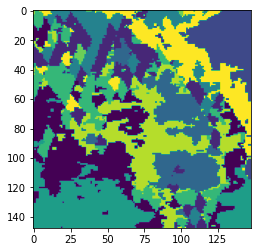

In [54]:
seg_dir = main_dir + r"/segmentation"
array_pred,centers = classification(agr_dir,seg_dir,projection,N=10,epsilon=0.001,T=100)

## Corrélation

In [25]:
def plot_correl(list1,list2,attribute=False,indice_corr="Pearson",savefig=False):

    if indice_corr == "Pearson":
        corr, _ = pearsonr(list1, list2)
    elif indice_corr == "Spearman":
        corr, _ = spearmanr(list1, list2)

    if attribute:
        color_list = ["red","green","blue","orange","yellow","pink","black","purple","beige","brown","gray","cyan"]
        colors = [color_list[np.where(np.unique(attribute)==loc)[0][0]] for loc in attribute]
        plt.scatter(list1,list2,c=colors,s=60, alpha=0.8)
        for i in range(len(np.unique(attribute))):
            print(color_list[i],"\t",np.unique(attribute)[i])
    else:
        plt.scatter(list1,list2,s=60, alpha=0.8)
    plt.title(f"indice de corrélation de {indice_corr}: {round(corr,3)}")
    plt.xlabel("pluviommétrie moyenne (mm/h)")
    plt.ylabel("TB SSMIS 91H (K)")
    
    if savefig:
        plt.savefig(savefig, dpi=500)

../../data/pluie_sol/gg_12-20_1h.csv
816 lignes ont été écartées, il s'agit probablement de lignes vides
128


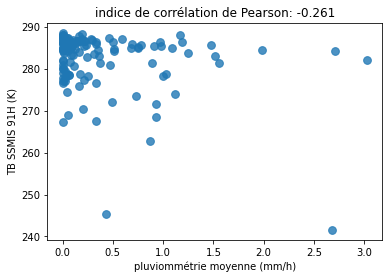

In [32]:
gt_fn = r"../../data/pluie_sol/gg_12-20_1h.csv"
mtd_fn = r"../../data/pluie_sol/gauges_guyane_metadata.csv"

proj_st_geo = r"../../data/param_proj/param_St_Georges.json"
proj_st_lau = r"../../data/param_proj/param_St_Laurent.json"
proj_test = r"../../data/param_proj/test.json"
projection_path = projection_path
param_proj = json.load(open(proj_st_geo, "r", encoding="utf-8"))

savefig = r"../../rapports/images/correlation_TBMOtrop_VT_guy.png"

#rain_rate
key,sdk,edk = "SSMIS_tif_91V","start_date_91V","end_date_91V"
true_rain,estim_rain,locations = combine_image_with_GT(index_path,gt_fn,mtd_fn,key,projection,end_date_key=edk,start_date_key=sdk)

A,B = [],[]
for i in range(len(true_rain)):
    if (not np.isnan(true_rain[i]) and (not estim_rain[i]==0)):
        A.append(estim_rain[i])
        B.append(rain_gt[i])

print(len(A))
plot_correl(B,A,attribute=False,indice_corr="Pearson",savefig=False)
